#Step 2
Now we make the model light by reducing the number of channels in all the layers.

#Results:
*   Parameters: 9.9k
*   Best Train Accuracy: 99.27
*   Best Test Accuracy: 98.86


#Analysis
*   The model has very less parameters compared to model 1
and the accuracy of the model dropped a little.
*   Next we try to gain back the accuracy of the model keeping the number of paramters same. The accuracy at this point is less than what we aim for. So, we try to acclerate the training.


#Journey of the model
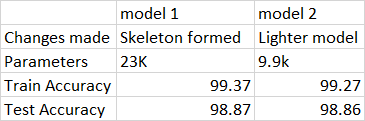

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ML_assignment/ERA_V1/S7/ToSubmit/"

Mounted at /content/drive
/content/drive/MyDrive/ML_assignment/ERA_V1/S7/ToSubmit


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import train_model, test_model
from utils import plot_data, plot_loss_accuracy

In [ ]:
# Device configuration -use CUDA tensor types if available
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print("CUDA Available?", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

CUDA Available? False


In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),   #convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), #normalize test with  mean=0.1307 & standard deviation 0.3081
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) #apply the same normalization of train set to test set
    ])

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) #loads train-images-idx3-ubyte: training set images
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)  #loads t10k-images-idx3-ubyte

In [ ]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

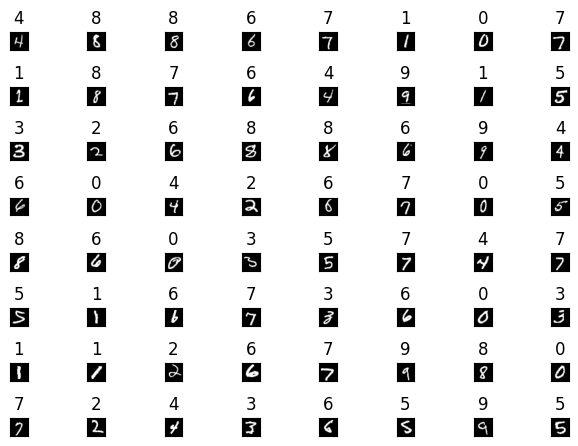

In [ ]:
import matplotlib.pyplot as plt
batch_data, batch_label = next(iter(train_loader))
# batch_data, batch_label = next(iter(test_loader))
plot_data(batch_data, batch_label, 64, 8, 8)

In [ ]:
#This class contains the architecture of the neural network
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, bias=False, padding=1), #Image Input: 28x28x1 -> 28x28x16  #Receptive Field 1 -> 3
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, bias=False), #Input: 28x28x16 -> 26x26x32  #Receptive Field 3 -> 5
        nn.ReLU(),
        #Transition Block = MaxPool + 1x1 Convolution
        #nn.Conv2d(16, 8, 1, bias=False),
        nn.MaxPool2d(2, 2),    #Input: 13x13x32 -> 13x13x32  #Receptive Field  5 -> 6
        nn.Conv2d(16, 8, 1, bias=False)   #Input: 13x13x32 -> 13x13x16  #Receptive Field  6 -> 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 8, 3, bias=False),  #Input: 13x13x16 -> 11x11x16  #Receptive Field  6 -> 10
        nn.ReLU(),
        nn.Conv2d(8, 8, 3, bias=False),  #Input: 11x11x16 -> 9x9x32  #Receptive Field  10 -> 14
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, bias=False),  #Input: 9x9x32 -> 7x7x16  #Receptive Field  14 -> 18
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, bias=False),  #Input: 7x7x16 -> 5x5x16  #Receptive Field  18 -> 22
        nn.ReLU()
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(16, 10, kernel_size=(5, 5), bias=False) #Input: 5x5x16 -> 1x1x10  #Receptive Field  22 -> 30
        )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]           1,152
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6            [-1, 8, 13, 13]             128
            Conv2d-7            [-1, 8, 11, 11]             576
              ReLU-8            [-1, 8, 11, 11]               0
            Conv2d-9              [-1, 8, 9, 9]             576
             ReLU-10              [-1, 8, 9, 9]               0
           Conv2d-11             [-1, 16, 7, 7]           1,152
             ReLU-12             [-1, 16, 7, 7]               0
    

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
#Negative log likelihood loss function is used to classify 10 classes [0-9 digits]
criterion = nn.NLLLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train_model(model, device, train_loader, optimizer, criterion)
  train_accuracy.append(train_acc)
  train_losses.append(train_loss)
  test_acc, test_loss = test_model(model, device, test_loader, criterion)
  test_accuracy.append(test_acc)
  test_losses.append(test_loss)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0919 Batch_id=468 Accuracy=71.29: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]


Test set: Average loss: 0.0010, Accuracy: 9569/10000 (95.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0509 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:45<00:00, 10.39it/s]


Test set: Average loss: 0.0008, Accuracy: 9677/10000 (96.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0779 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]


Test set: Average loss: 0.0005, Accuracy: 9767/10000 (97.67%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0693 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Test set: Average loss: 0.0005, Accuracy: 9791/10000 (97.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0193 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:45<00:00, 10.29it/s]


Test set: Average loss: 0.0004, Accuracy: 9821/10000 (98.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0543 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


Test set: Average loss: 0.0004, Accuracy: 9844/10000 (98.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0132 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:44<00:00, 10.58it/s]


Test set: Average loss: 0.0003, Accuracy: 9884/10000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0574 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:47<00:00,  9.84it/s]


Test set: Average loss: 0.0003, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0287 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:47<00:00,  9.85it/s]


Test set: Average loss: 0.0003, Accuracy: 9875/10000 (98.75%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0592 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]


Test set: Average loss: 0.0003, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0109 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:43<00:00, 10.80it/s]


Test set: Average loss: 0.0003, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0174 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]


Test set: Average loss: 0.0003, Accuracy: 9884/10000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0321 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:43<00:00, 10.66it/s]


Test set: Average loss: 0.0003, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0103 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:43<00:00, 10.73it/s]


Test set: Average loss: 0.0003, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0249 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:42<00:00, 11.11it/s]


Test set: Average loss: 0.0003, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-04.


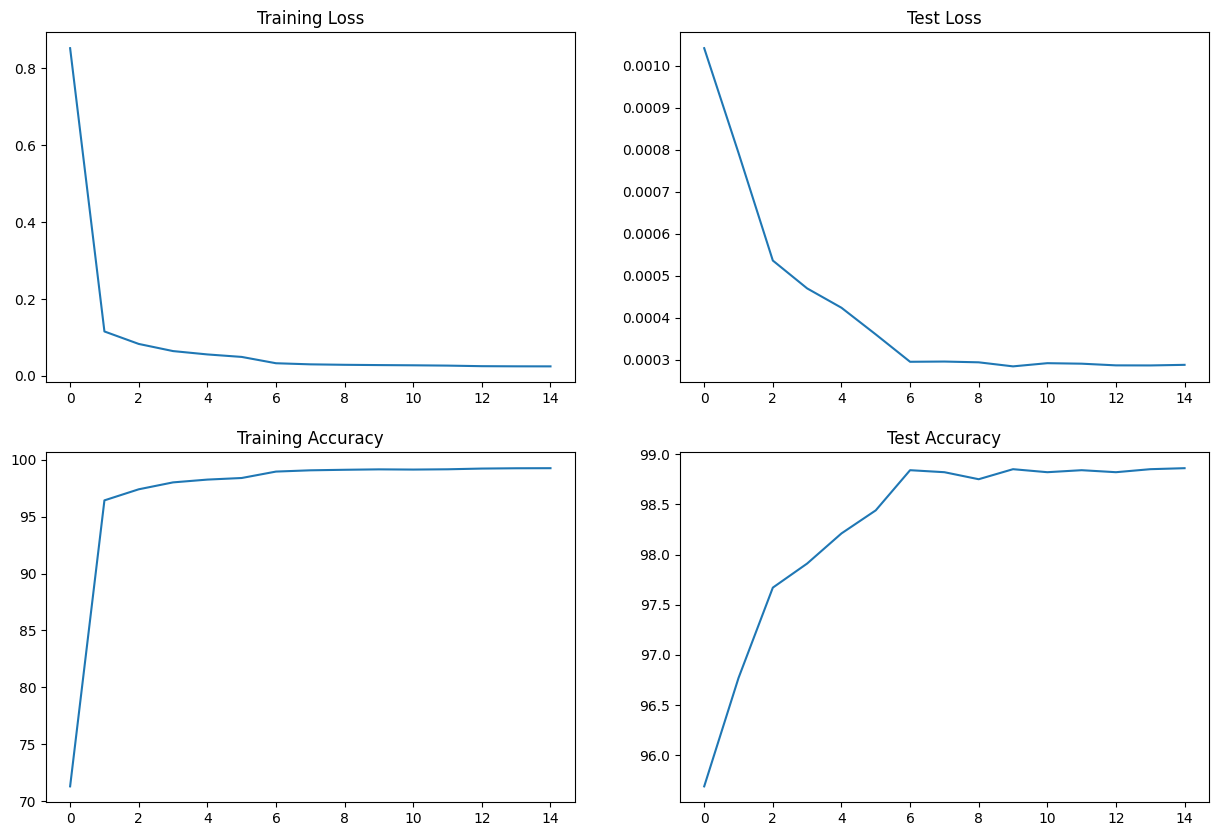

In [ ]:
plot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)